In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import skimage.io as io
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os
import pickle
import pydicom
from metrics import Pfbeta

In [3]:
DATA_DIR = Path('input/rsna-breast-cancer-detection/')

In [4]:
train = pd.read_csv(DATA_DIR/'train.csv')

# Load experiment

In [5]:
from datasets import *
from architectures import *
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
from transforms import *
from configs import *
from kuma_utils.utils import sigmoid

In [6]:
# def plot_color_gradients(cmap_name):
#     gradient = np.linspace(0, 1, 256)
#     gradient = np.vstack((gradient, gradient))
#     # Create figure and adjust figure height to number of colormaps
#     plt.figure(figsize=(10, 1))
#     plt.imshow(gradient, aspect='auto', cmap=plt.cm.get_cmap(cmap_name))
#     plt.axis('off')

# plot_color_gradients('jet')

In [7]:
# cfg = Dataset02v0()
# ds = PatientLevelDataset(
#     df=train, image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'),
#     flip_lr=False,
#     preprocess=A.Compose([AutoFlip(), CropROI(threshold=0.1, buffer=160), A.Resize(768, 384)]),
#     transforms=ToTensorV2(),
#     # preprocess=cfg.preprocess['train'],
#     # transforms=cfg.transforms['train']
# )

In [6]:
cfg = Model05v2()
# model = cfg.model(**cfg.model_params)

In [115]:
with open(f'results/{cfg.name}/predictions.pickle', 'rb') as f:
    predictions = pickle.load(f)

In [116]:
# for fold_i, pred_fold in enumerate(predictions['outoffolds']):
#     sns.distplot(sigmoid(pred_fold), bins=50, label=f'fold{fold_i}')
# plt.legend()
# plt.show()

In [7]:
SAMPLE_ID = {
    42624, 48001, 48514, 2179, 31107, 23554, 13185, 53255, 
    29192, 59530, 64908, 32527, 13845, 59552, 54816, 49954, 
    55330, 59307, 21934, 63536, 23729, 61490, 61874, 16955, 
    46014, 38727, 64456, 50375, 9162, 55755, 25550, 15696, 
    50002, 58195, 10198, 13016, 25050, 31581, 26333, 29664, 
    8289, 3305, 6637, 48493, 58610, 42231, 12282, 9083, 32252, 39677}

(0.6808510638297872, 0.01)


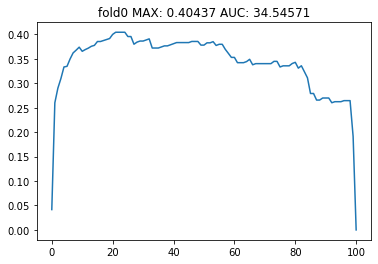

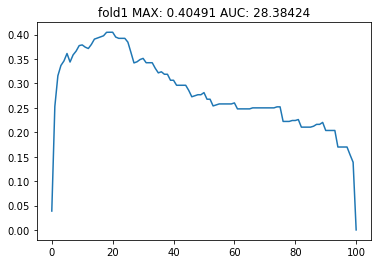

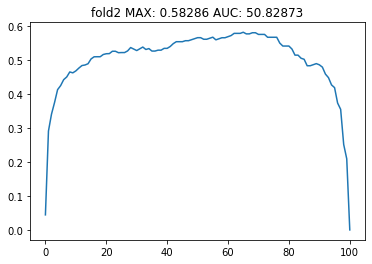

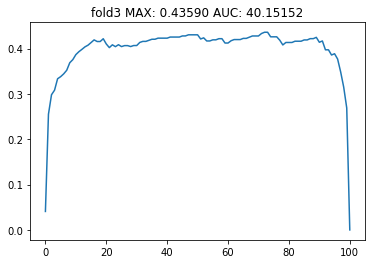

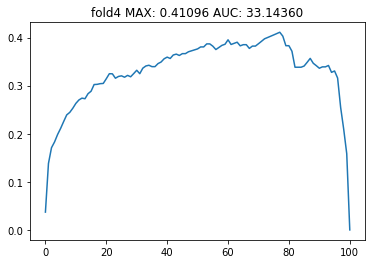

In [118]:
metric = Pfbeta(binarize=True)
for fold_i, (folds, pred_fold) in enumerate(zip(predictions['folds'], predictions['outoffolds'])):
    ds = cfg.dataset(
        df=train.iloc[folds[1]], image_dir=Path('input/rsna-breast-cancer-detection/image_resized_1024W'))
    labels = ds.get_labels()
    scores, thres = metric.optimal_f1_all(labels, sigmoid(pred_fold))
    if fold_i == 0:
        # pos_idx = np.random.choice(np.where(labels == 1)[0], size=25, replace=False).tolist()
        # neg_idx = np.random.choice(np.where(labels == 0)[0], size=25, replace=False).tolist()
        # pids = set()
        # for idx in pos_idx+neg_idx:
        #     pids.add(ds.pids[idx][0])
        valid_idx = []
        for i in range(len(ds)):
            valid_idx.append(ds.pids[i][0] in SAMPLE_ID)
        score = metric.optimal_f1(labels[valid_idx], sigmoid(pred_fold)[valid_idx])
        print(score)
    plt.plot(scores)
    plt.title(f'fold{fold_i} MAX: {max(scores):.5f} AUC: {sum(scores):.5f}')
    plt.show()